## Object Oriented Code for the Neural Net

In [17]:
import numpy as np     #Importing this library to make computaion slightly faster

###START OF NEURON CLASS###
class Neuron:     #Defining a Neuron Class that can only be called from inside the Layer Class
    def __init__(self):  #Initialization block for the Neuron. Doesn't take any inputs
        self.type = 'relu' #By default, a neuron object will be of the 'relu' type
        self.fp = 0 #To store the value of the forward propagation for the given neuron
        self.z = 0 #To store the wrighted sum
        self.W = [] #To store the input weights
        self.b = 0 #To store the bias of the neuron
        self.ac_1 = [] #To store the activations(inputs) from the previous layer
        self.dz=0 #To store the gradient generated during backpropagation

    def _weighted_sum(self): #Calculating the weighted sum z = w*x + b
        summ = 0
        for i in range(len(self.ac_1)):
            summ+=self.ac_1[i]*self.W[i]
        return summ + self.b

    def _activation_fn(self): #Calculating the activation based on the type of the neuron
        if(self.type=='relu'): # a = max(0,z)
            if self.z > 0:
                return self.z
            return 0
        elif(self.type=='sigm'): # a = 1/(1+e^-z)
            return 1/(1+np.exp(-self.z))
        else:
            raise Exception('Invalid Activation Function')

    def forward_propagate(self,inp,weights,bias,choice='relu'): #Calculating the output of the neuron given inputs, weights and bias
        assert(len(inp)==len(weights))
        self.type=choice
        self.ac_1 = inp
        self.W = weights
        self.b = bias
        self.z = self._weighted_sum()
        self.fp = self._activation_fn()
        return self.fp

    def _back_activation_fn(self): #Calculating the derivative wrt to the cost based on the activation function being used
        if(self.type=='relu'):
            if(self.z<0):
                return 0
            else:
                return self.dac
        elif(self.type=='sigm'):
            return self.dac*self.fp*(1-self.fp)
        else:
            raise Exception("Invalid activation function")

    def back_propagate(self,dac): #Outputs the backpropagation outputs to calculate the gradients for the current and the previous layers
        self.dac = dac
        self.dz = self._back_activation_fn()
        m = len(self.ac_1)
        dw = np.array(self.ac_1)*self.dz
        db = self.dz
        dac_1 = np.array(self.W)*self.dz
        return dw,db,dac_1
###END OF NEURON CLASS###

###START OF LAYER CLASS###
class Layer:      #Defining a Layer class that can only be called from inside the Neural_Net Class
    def __init__(self, n_neurons): #Initialization block for the Layer Class. Takes the number of Neurons to be present as input.
        self.neurons = [] #List to store the Neuron objects created using the Neuron Class
        self.n_neurons = n_neurons #Storing the input value of the number of neurons to be present in the Layer
        for i in range(self.n_neurons): #Populating the Layer with the objects of the Neuron Class
            self.neurons.append(Neuron())

    def forward_propagate(self, inputs, weights,bias,choice='relu'):#Outputs the forward propagation of the layers to be used as input for furthe layers
        output = []
        for i in range(self.n_neurons):
            output.append(self.neurons[i].forward_propagate(inputs,weights[i],bias[i],choice))
        return output

    def back_propagate(self,dacs): #Outputs the gradients required to update weights and biases of the current layer 
        dacs=np.array(dacs.mean(axis=0))
        dws = []
        dbs = []
        dac_1s = []
        for i in range(dacs.shape[0]):
            temp1,temp2,temp3 = self.neurons[i].back_propagate(dacs[i])
            dws.append(temp1)
            dbs.append(temp2)
            dac_1s.append(temp3)
        return np.array(dws),np.array(dbs),np.array(dac_1s)
###END OF LAYER CLASS###

###START OF NEURAL_NET CLASS###
class Neural_Net:      #Defining the Class for the Neural_Net
    def __init__(self, layers): #Initialization block for the Neural Network. Takes the number of layers and the the number of neurons per layer as input in the form of a list
        self.n_layers=len(layers)   #Keeps track of the number of hidden layers in the Neural Network
        self.inputs=None  #To store the inputs during each iteration of forward propagation
        self.outputs=None #To store the corresponding correct outputs during each iteration of forward propagation
        self.Layers=[] #List to store all the objects created using the Layer Class
        self.Weights=[] #List to store all the Weights of the Network
        self.WGrads = [] #List to store all the Gradients of the Weights generated after every epoch
        self.Bias=[] #List to store all the Biases of the Network
        self.BGrads = [] #List to store the Gradients of the Biases generated after every epoch
        self.layers=layers #Storing the input list used to create the Network Architecture
        self.learning_rate = 0 #Learning Rate for the network that is used for Updating the Weights
        self.n_inps = 0 #Storing the number of inputs to the network
        self.inputs_val = None #To store the inputs of the validation/test set for each iteration fo the forward propagation
        self.outputs_val = None #To store the corresponding correct outputs of the validation/test set
        
    def _showWandB(self): #Outputs the weights and biases of the network. Used for sanity checks
        print('Weights:',self.Weights)
        print('Bias:',self.Bias)
        
    def _showGWandBG(self): #Outputs the gradients of the weights and biases of the network. Used for sanity checks
        print('WGrads:',self.WGrads)
        print('BGrads:',self.BGrads)
        
    def _initialize(self): #Initializing the Network with the appropriate parameters
        for i in range(self.n_layers):
            self.Layers.append(Layer(self.layers[i]))
            if i==0:
                self.Weights.append(np.random.randn(self.layers[i],len(self.inputs[0])))#####
                self.Bias.append(np.random.randn(self.layers[0]))
            else:
                self.Weights.append(np.random.randn(self.layers[i],self.layers[i-1]))
                self.Bias.append(np.random.randn(self.layers[i]))
        self.Layers.append(Layer(1))
        self.Weights.append(np.random.randn(1,self.layers[self.n_layers-1]))
        self.Bias.append(np.random.randn(1))
                
    def _forward_propagate(self,temp): #Outputs the predictive value of the network wrt to the input sample and current weights nad biases
        for i in range(len(self.Layers)):
            if i==0:
                temp = self.Layers[i].forward_propagate(temp,self.Weights[i],self.Bias[i],'relu')
            elif i==self.n_layers:
                temp = self.Layers[i].forward_propagate(temp,self.Weights[i],self.Bias[i],choice='sigm')
            else:
                temp = self.Layers[i].forward_propagate(temp,self.Weights[i],self.Bias[i],'relu')
        return temp
    
    def _compute_cost(self,pred,act,cost_type = 'crs_ent'): #Computes the cost using the correct outputs
        temp_out = np.array(pred)
        act=np.array(act)
        act = np.expand_dims(act,axis=0)
        m = act.shape[0]
        if(cost_type == 'mse'):
            cost = (1/(2*m))*(np.array(temp_out)-np.array(act))**2
            cost_der = np.array(temp_out)-np.array(act)
        elif(cost_type == 'crs_ent'):
#             print("m is ", m)
            if(temp_out==1):
                temp_out-=0.00001
            elif(temp_out==0):
                temp_out+=0.00001
            cost = (-1 / m) * (np.multiply(act, np.log(temp_out)) + np.multiply(1 - act, np.log(1 - temp_out)))
            cost_der =  (-1/m)* (np.divide(act, temp_out) - np.divide(1 - act, 1 - temp_out))
        else:
            raise Exception('Invalid cost function given.')
        return cost,cost_der
    
    def _back_propagate(self,cost_der): #Backpropogate the error to calculate the gradients for all the weights and biases
        temp3 = np.array(cost_der)
        temp3 = np.expand_dims(temp3,axis=1)
        Wg = []
        Bg = []
        for i in reversed(range(len(self.Layers))):
            temp1, temp2, temp3 = self.Layers[i].back_propagate(temp3)
            Wg.insert(0,temp1)
            Bg.insert(0,temp2)
        return Wg,Bg
                
    def _update_weights(self): #Updates the weights and biases with the calculated gradient
        for i in range(len(self.Layers)):
            self.Weights[i] = self.Weights[i] - self.learning_rate * self.WGrads[i]
            self.Bias[i] = self.Bias[i] - self.learning_rate * self.BGrads[i]
     
    def train(self,inps,outs,inp_val,out_val,epochs=50,learning_rate = 0.03,printCost=False,printEvery = 10, printFrom = 0):
        #Function to run the training loop for the given number of epochs
        self.inputs = inps
        self.outputs = outs
        self.inputs_val = inp_val
        self.outputs_val = out_val
        self.learning_rate = learning_rate
        self._initialize()
        cost_av = 0
        cost_der_av = 0
        self.n_inps = self.inputs.shape[0]
        costs = []
        trn_acc = []
        tst_acc = []
        WGtemp = []
        BGtemp = []
        xaxis = []
        for i in range(epochs):
            for j in range(len(self.inputs)):
                pred = self._forward_propagate(self.inputs[j])
#                 print(pred,end=" ")
                cost,cost_der = self._compute_cost(pred,self.outputs[j])
                WGtemp,BGtemp=self._back_propagate(cost_der)
                cost_av+=cost
                cost_der_av+=cost_der
                if(j==0):
                    self.WGrads = WGtemp
                    self.BGrads = BGtemp
                else:
                    for k in range(len(self.Layers)):
                        self.WGrads[k]=self.WGrads[k]+WGtemp[k]
                        self.BGrads[k]=self.BGrads[k]+BGtemp[k]
            for j in range(len(self.Layers)):
                self.WGrads[j]=self.WGrads[j]/self.n_inps
                self.BGrads[j]=self.BGrads[j]/self.n_inps
            cost_av/=self.n_inps
            cost_der_av/=self.n_inps
            if(printCost and i%printEvery==0 and i>=printFrom):# and i!=0 and i>10):
                print("Epoch %d/%d,"%(i+1,epochs),end=" ")
                print("Cost = %f,"%(cost_av),end=" ")
                _,acc1 = self.predict_classes(self.inputs,self.outputs)
                _,acc2 = self.predict_classes(self.inputs_val, self.outputs_val)
                print("Training Accuracy = %f, Validation Accuracy = %f"%(acc1,acc2))
                trn_acc.append(acc1)
                tst_acc.append(acc2)
                xaxis.append(i)
                costs.append(cost_av[0])
#             self._showGWandBG()
            self._update_weights()
        print("Epoch %d/%d,"%(epochs,epochs),end=" ")
        print("Cost = %f,"%(cost_av),end=" ")
        _,acc1 = self.predict_classes(self.inputs,self.outputs)
        _,acc2 = self.predict_classes(self.inputs_val, self.outputs_val)
        print("Training Accuracy = %f, Validation Accuracy = %f"%(acc1,acc2))
        #Plotting the results
        plt.subplot(2, 1, 1)
        plt.plot(np.squeeze(costs)) #Plotting the cost function
        plt.ylabel('Cost')
        plt.xlabel('Epochs')
        plt.title("Cost FUnction (Learning rate = " + str(self.learning_rate)+")")
        plt.subplot(2, 1, 2)
        plt.plot(xaxis,trn_acc) #Plotting the training accuracies
        plt.plot(xaxis,tst_acc) #Plotting the test accuracies
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(['Train Acc', 'Test Acc'])
        plt.title("Training and Test Acuuracies")
        plt.show()

    def predict(self,p): #Predicting the outputs for all the given inputs
        preds = []
        for temp in p:
            for i in range(len(self.Layers)):
                if i==0:
                    temp = self.Layers[i].forward_propagate(temp,self.Weights[i],self.Bias[i],'relu')
                elif i==self.n_layers:
                    temp = self.Layers[i].forward_propagate(temp,self.Weights[i],self.Bias[i],choice='sigm')
                else:
                    temp = self.Layers[i].forward_propagate(temp,self.Weights[i],self.Bias[i],'relu')
            preds.append(temp)
        return preds
    
    def predict_classes(self,p,q): #Predicting the classes for the given inputs and also calculating the accuracy
        preds = np.array(self.predict(p))
        preds[preds>0.5]=1
        preds[preds<=0.5]=0
        preds = np.squeeze(preds)
        acc = np.sum((preds == q)/p.shape[0])
        return preds,acc
###END OF NEURAL_NET CLASS### 

## Importing and Preprocessing Data

In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data = pd.read_csv('./diabetes.csv')

inputs = data.drop('Outcome', axis = 1)
inputs = np.array(inputs) #Converting the input Pandas Series object into a numpy array

from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = MinMaxScaler() #Using a MinMaxScalar to linearly transform the data
inputs = sc.fit_transform(inputs)
outputs = data['Outcome'].as_matrix() #Converting the output Pandas Series object into a numpy array

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.10, random_state=42) #Splitting the test set

plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots

/home/rishi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Epoch 1/400, Cost = 2.005995, Training Accuracy = 0.348770, Validation Accuracy = 0.350649
Epoch 2/400, Cost = 0.778340, Training Accuracy = 0.348770, Validation Accuracy = 0.350649
Epoch 3/400, Cost = 0.759813, Training Accuracy = 0.348770, Validation Accuracy = 0.350649
Epoch 4/400, Cost = 0.745755, Training Accuracy = 0.350217, Validation Accuracy = 0.350649
Epoch 5/400, Cost = 0.733521, Training Accuracy = 0.350217, Validation Accuracy = 0.350649
Epoch 6/400, Cost = 0.722724, Training Accuracy = 0.350217, Validation Accuracy = 0.350649
Epoch 7/400, Cost = 0.713096, Training Accuracy = 0.350217, Validation Accuracy = 0.350649
Epoch 8/400, Cost = 0.704437, Training Accuracy = 0.350217, Validation Accuracy = 0.350649
Epoch 9/400, Cost = 0.696589, Training Accuracy = 0.350217, Validation Accuracy = 0.350649
Epoch 10/400, Cost = 0.689442, Training Accuracy = 0.350217, Validation Accuracy = 0.350649
Epoch 11/400, Cost = 0.682927, Training Accuracy = 0.697540, Validation Accuracy = 0.7012

Epoch 91/400, Cost = 0.557450, Training Accuracy = 0.736614, Validation Accuracy = 0.727273
Epoch 92/400, Cost = 0.557002, Training Accuracy = 0.736614, Validation Accuracy = 0.727273
Epoch 93/400, Cost = 0.556561, Training Accuracy = 0.736614, Validation Accuracy = 0.727273
Epoch 94/400, Cost = 0.556127, Training Accuracy = 0.739508, Validation Accuracy = 0.727273
Epoch 95/400, Cost = 0.555698, Training Accuracy = 0.735166, Validation Accuracy = 0.727273
Epoch 96/400, Cost = 0.555278, Training Accuracy = 0.736614, Validation Accuracy = 0.727273
Epoch 97/400, Cost = 0.554866, Training Accuracy = 0.738061, Validation Accuracy = 0.727273
Epoch 98/400, Cost = 0.554460, Training Accuracy = 0.738061, Validation Accuracy = 0.727273
Epoch 99/400, Cost = 0.554061, Training Accuracy = 0.739508, Validation Accuracy = 0.727273
Epoch 100/400, Cost = 0.553668, Training Accuracy = 0.739508, Validation Accuracy = 0.727273
Epoch 101/400, Cost = 0.553282, Training Accuracy = 0.739508, Validation Accura

Epoch 180/400, Cost = 0.531380, Training Accuracy = 0.749638, Validation Accuracy = 0.727273
Epoch 181/400, Cost = 0.531146, Training Accuracy = 0.749638, Validation Accuracy = 0.727273
Epoch 182/400, Cost = 0.530918, Training Accuracy = 0.749638, Validation Accuracy = 0.727273
Epoch 183/400, Cost = 0.530692, Training Accuracy = 0.749638, Validation Accuracy = 0.727273
Epoch 184/400, Cost = 0.530469, Training Accuracy = 0.749638, Validation Accuracy = 0.727273
Epoch 185/400, Cost = 0.530230, Training Accuracy = 0.749638, Validation Accuracy = 0.727273
Epoch 186/400, Cost = 0.529997, Training Accuracy = 0.749638, Validation Accuracy = 0.727273
Epoch 187/400, Cost = 0.529765, Training Accuracy = 0.749638, Validation Accuracy = 0.727273
Epoch 188/400, Cost = 0.529528, Training Accuracy = 0.749638, Validation Accuracy = 0.727273
Epoch 189/400, Cost = 0.529297, Training Accuracy = 0.749638, Validation Accuracy = 0.727273
Epoch 190/400, Cost = 0.529069, Training Accuracy = 0.749638, Validati

Epoch 269/400, Cost = 0.512935, Training Accuracy = 0.759768, Validation Accuracy = 0.753247
Epoch 270/400, Cost = 0.512763, Training Accuracy = 0.759768, Validation Accuracy = 0.753247
Epoch 271/400, Cost = 0.512592, Training Accuracy = 0.759768, Validation Accuracy = 0.753247
Epoch 272/400, Cost = 0.512421, Training Accuracy = 0.759768, Validation Accuracy = 0.753247
Epoch 273/400, Cost = 0.512252, Training Accuracy = 0.759768, Validation Accuracy = 0.753247
Epoch 274/400, Cost = 0.512082, Training Accuracy = 0.759768, Validation Accuracy = 0.753247
Epoch 275/400, Cost = 0.511912, Training Accuracy = 0.761216, Validation Accuracy = 0.753247
Epoch 276/400, Cost = 0.511743, Training Accuracy = 0.761216, Validation Accuracy = 0.753247
Epoch 277/400, Cost = 0.511576, Training Accuracy = 0.761216, Validation Accuracy = 0.753247
Epoch 278/400, Cost = 0.511409, Training Accuracy = 0.761216, Validation Accuracy = 0.753247
Epoch 279/400, Cost = 0.511244, Training Accuracy = 0.762663, Validati

Epoch 358/400, Cost = 0.498163, Training Accuracy = 0.758321, Validation Accuracy = 0.714286
Epoch 359/400, Cost = 0.497975, Training Accuracy = 0.758321, Validation Accuracy = 0.714286
Epoch 360/400, Cost = 0.497791, Training Accuracy = 0.758321, Validation Accuracy = 0.714286
Epoch 361/400, Cost = 0.497589, Training Accuracy = 0.758321, Validation Accuracy = 0.714286
Epoch 362/400, Cost = 0.497391, Training Accuracy = 0.758321, Validation Accuracy = 0.714286
Epoch 363/400, Cost = 0.497194, Training Accuracy = 0.758321, Validation Accuracy = 0.714286
Epoch 364/400, Cost = 0.497001, Training Accuracy = 0.758321, Validation Accuracy = 0.714286
Epoch 365/400, Cost = 0.496812, Training Accuracy = 0.756874, Validation Accuracy = 0.714286
Epoch 366/400, Cost = 0.496623, Training Accuracy = 0.758321, Validation Accuracy = 0.714286
Epoch 367/400, Cost = 0.496439, Training Accuracy = 0.758321, Validation Accuracy = 0.714286
Epoch 368/400, Cost = 0.496256, Training Accuracy = 0.758321, Validati

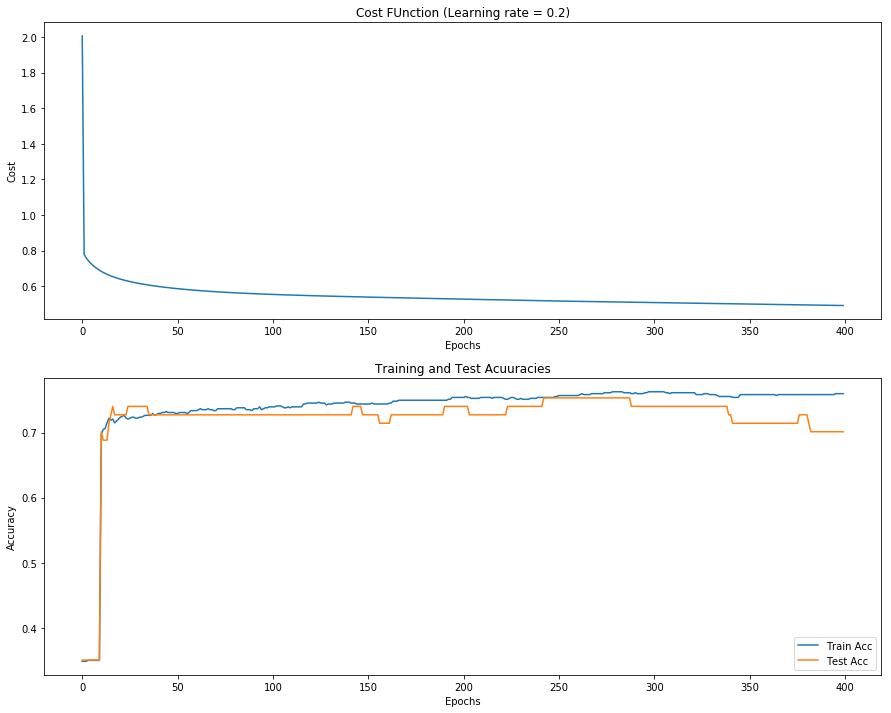

In [22]:
np.random.seed(10) #Setting a random seed for reproducability and sanity checks
net = Neural_Net([10,5]) #Creating a Neural_Net object
net.train(X_train,y_train,X_test,y_test,epochs=400,learning_rate=0.2,printCost=True,printEvery=1, printFrom = 0) #Training the Neural Network